In [1]:
from collections import Counter
import os

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from imutils.paths import list_images
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torchvision import transforms
from sklearn.metrics import *
from torch import optim
from torch import nn
import pandas as pd
import numpy as np
import torch
import timm
import cv2

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/Pneumonia'

In [3]:
args              = {}
args['seed']      = 999
args['device']    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['n_samples'] = 3
args['epochs']    = 15
args['lr']        = 1e-3
args['bs']        = 64
args              = edict(args)

In [4]:
class PneumoniaDataset(Dataset):
    
    def __init__(self, image_paths, dtype = 'train'):
        
        self.image_paths = image_paths
        self.dtype       = dtype
        
        self.transform          = {}
        self.transform['train'] = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((500, 500)),
                                    transforms.CenterCrop(350),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()
                                ])
        
        self.transform['test']  = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((500, 500)),
                                    transforms.CenterCrop(350),
                                    transforms.ToTensor()
                                 ])
    
    
    def __len__(self): return len(self.image_paths)


    def __getitem__(self, idx):
        
        image = cv2.imread(self.image_paths[idx])
        label = self.image_paths[idx].split(SEP)[-2]
        image  = self.transform[self.dtype](image)
        
        return image, lb2idx[label]
        

In [5]:
lb_cnt      = lambda paths: Counter([path.split(SEP)[-2] for path in paths])

train_paths = sorted(list_images(f'{DATA_PATH}/train'))
test_paths  = sorted(list_images(f'{DATA_PATH}/test'))
valid_paths = sorted(list_images(f'{DATA_PATH}/val'))

train_cnt   = lb_cnt(train_paths)
test_cnt    = lb_cnt(test_paths)
valid_cnt   = lb_cnt(valid_paths)

lb2idx      = {lb  : idx for idx,  lb in enumerate(['normal', 'pneumonia'])}
idx2lb      = {idx : lb  for lb , idx in lb2idx.items()}

In [6]:
train_dataset = PneumoniaDataset(train_paths)
image, label  = train_dataset.__getitem__(0)

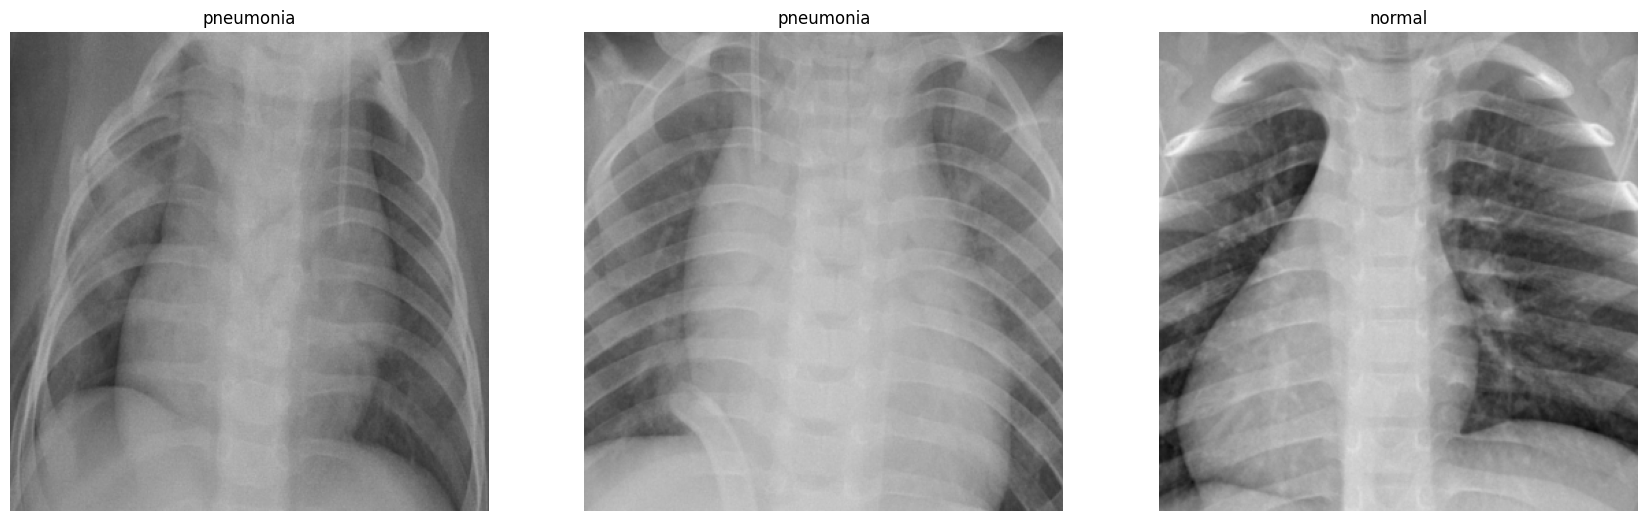

In [7]:
random_idx    = np.random.randint(0, len(train_dataset), args.n_samples)
_, axes       = plt.subplots(1, args.n_samples, figsize = (7 * args.n_samples, 7))

for ax, idx in zip(axes, random_idx):
    
    image, label = train_dataset.__getitem__(idx)
    ax.imshow(image.numpy().transpose(1, 2, 0))
    ax.set_title(idx2lb[label])
    ax.axis(False)